# <center>Structural Analysis and Visualization of Networks</center>

## <center/>Course Project #2

### <center>Student: *{German Sokolov}*</center>

#### <hr /> General Information

**Due Date:** 17.06.2015 23:59 <br \>
**Late submission policy:**  <br \>


Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2016] *{LastName}* *{First Name}* Project*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Description

### Data

As a dataset to analyse you can choose one option in the following list:
1. Real Dataset (can be found [here](http://snap.stanford.edu/) or [here](http://konect.uni-koblenz.de/networks/))
2. Generated Dataset. Use more complex structure rather than just a simple ER model. For instance, you may consider multilevel network, where on the lower level you have several Watts-Strogatz graphs and on the upper level these graphs are respesented as randomly connected nodes.
3. Your data mined from Social Networks, Twitter, LiveJournal e.t.c.

**The order of your dataset should be no less than $10^4$ nodes**

### Models

Consider one of the following models:
1. SIR-based (or another with more than 3 letters) epidemic model
2. Independent Cascade Model
3. Linear Threshold Model

### Tasks

#### Network Descriptive Analysis

Provide information on your netowork: Source, Descriptive Statistics, Visualization

#### Main Task for model (1)

You are in charge of leading the vaccination campaign against some outbroken nonlethal disease. You have options to vactinate or provide medical treatment to infected ones. However, everything has its costs:
* Vaccination of a node costs $500 \$$ and make it immune to the disease all life-long. Unfortunately, you can help this way only to no more than $10\%$ of your population
* Medical Treatment costs $120\$$ per day of illness period, which in turn may take from $3$ to $7$ days

Your task is to implement the simulation model, propose some vaccination strategies and compare them.

#### Main Task for models (2-3)

You are running the marketing campaign for brand new pocket device. Initially you can sign contracts with a few people to advertize your gadget among their neigbours. The more "famous" person you are picking the greater price appears in the contract.
* Contract cost can be calculated as $300 \$ \times \text{NN}(i)$, where $\text{NN}(i)$ is size of the neigbourhood of the person $i$.
* You earn $250\$$ per each affected person

Your task is to maximize your influence and maximize profit of your campaign

### Data download.

In [201]:
import urllib
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sbs
% matplotlib inline

In [4]:
url = "https://www.dropbox.com/s/8gutb46anxjytat/data.txt?dl=1"
data = urllib.request.urlopen(url)

### Network descriptive analysis.

This is the interaction network of online users, which contains about 10,000 nodes and 25,000 undirected edges.

In [5]:
# Create undirected graph by reading each line from the file and adding nodes/edges
G = nx.Graph()
iline = 0
for line in data.readlines():
    iline += 1
    if iline < 3:
        continue
    raw_line = line.split()
    node1 = raw_line[0].decode()
    node2 = raw_line[1].decode()
    G.add_edge(node1, node2)
print("Graph is created!!")    
print("Number of nodes: {:,d}".format(len(G.nodes())))
print("Number of edges: {:,d}".format(G.size()))

Graph is created!!
Number of nodes: 10,680
Number of edges: 24,316


Draw the graph:

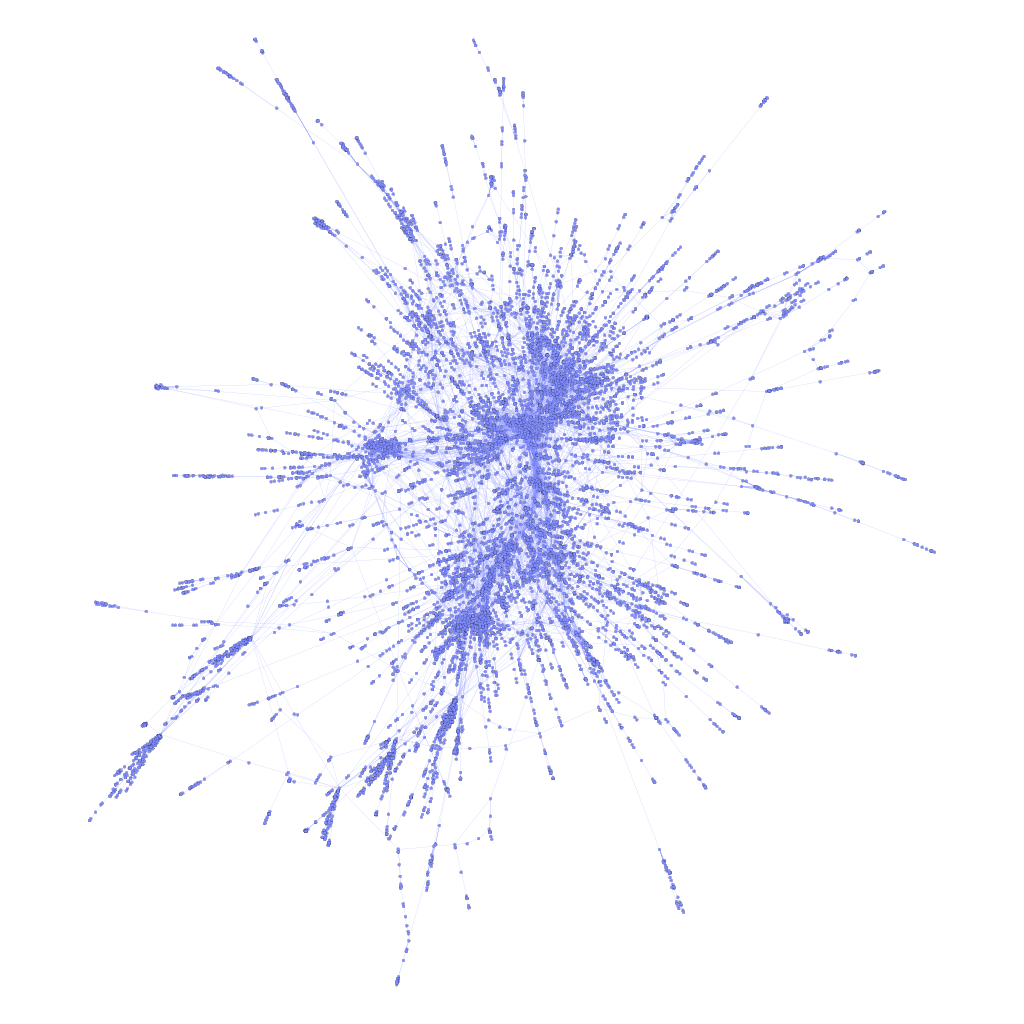

In [335]:
from IPython.display import Image
Image(filename='graph.png') 

Distribution of node degrees aligns with the power-law distribution: cCDF in log-log scales is almost straight line.

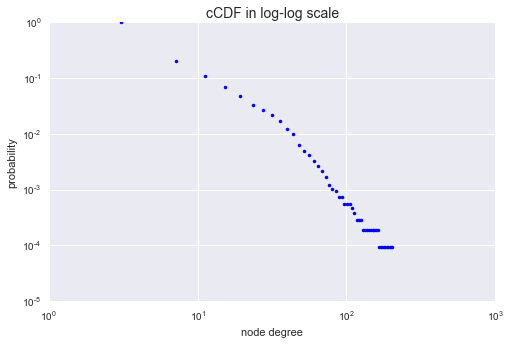

In [6]:
degrs = G.degree()
yh, binEdges = np.histogram(list(degrs.values()), bins=50)
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
plt.figure(figsize = (8,5))
plt.loglog(bincenters, np.cumsum(yh[::-1], dtype=float)[::-1] / np.cumsum(yh)[-1], 'b.')
plt.ylabel('probability')
plt.xlabel('node degree')
plt.title("cCDF in log-log scale", fontsize = 14)    

There is a single connected component.

In [7]:
print('Number of connected components: {:,d}'.format(nx.number_connected_components(G)))
largestCC = sorted(nx.connected_components(G), key = len, reverse=True)[0]
GraphLargestCC = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
print('Largest CC size: {:,d} nodes'.format(len(largestCC)))

Number of connected components: 1
Largest CC size: 10,680 nodes


Key statistics on network comply with main empirical properties of other networks:

* Power law distribution 
* Assortativity by node degrees
* Quite high clustering coefficient
* Pretty low value of graph diameter

The last point is actually arguable, because the network is not so dense and it might be quite long chain from one node to another, but still it is not so long as in conventional Small world model.   

In [9]:
print('Some statistics: \n')
print("Diameter of graph: {}".format(nx.diameter(GraphLargestCC)))
print("Average clustering coefficient: {:.2f}".format(nx.average_clustering(GraphLargestCC)))
print("Max node degree: {:,d}".format(max(degrs.values())))
print("Mean node degree: {:.1f}".format(np.array(list(degrs.values())).mean()))
print("Min node degree: {}".format(min(degrs.values())))
print("Assortativity by node degrees: {:.2f}".format(nx.degree_assortativity_coefficient(GraphLargestCC)))

Some statistics: 

Diameter of graph: 24
Average clustering coefficient: 0.27
Max node degree: 205
Mean node degree: 4.6
Min node degree: 1
Assortativity by node degrees: 0.24


The network structure almost surely contains several minor communities, where connections are more dense. It can be seen from adjacency matrix after reordering nodes.

In [10]:
# Reorder nodes to better visualize tight connections
reordered_nodes = list(nx.utils.reverse_cuthill_mckee_ordering(G))
adj_matrix = nx.to_scipy_sparse_matrix(G, nodelist = reordered_nodes)
degrs = np.asarray(adj_matrix.sum(axis=0))[0]
n = adj_matrix.shape[0]

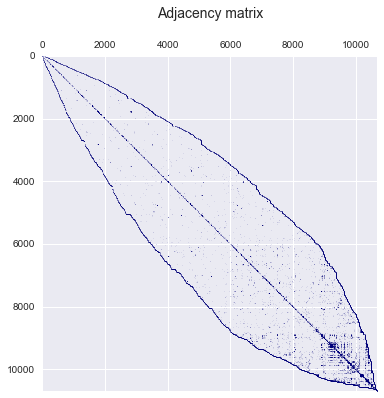

In [12]:
# Plot adjacency matrix with reordered lines
ax = plt.figure(figsize=(6, 6))
plt.spy(adj_matrix, markersize=0.2)
plt.title("Adjacency matrix", fontsize = 14, y = 1.1)

### Main task.

**Goal:** Maximize influence and profit from the campaign.
<br\>
<br\>
Reasonable assumption: if campaign has any positive effect, then the profit positively depends on influence until some optimal value. After that value, the increase in influence reduces profit, because the **marginal effect** or **marginal profit** becomes negative. In other words, the agents become "worse" and at some point it will not worth attracting them at all, as we attract the best ones at first.
<br\>
<br\>
More formally, the profit function might br **concave** and it could be possible to find its optimal value.

Simple example is illustrated below when the advertizing campaign has positive effect: 

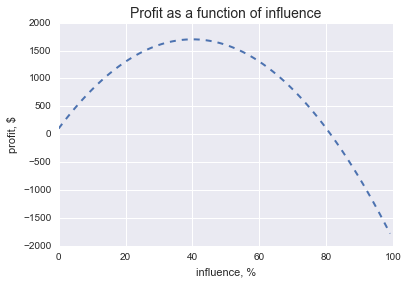

In [167]:
# Plot simple concave function
X = np.arange(0, 100, 1)
Y = -(X-30)**2 + 1000 + 20*X
plt.plot(X, Y, '--',lw = 2); plt.xlabel("influence, %"); plt.ylabel("profit, $"); 
plt.title("Profit as a function of influence", fontsize = 14)

It is worth noticing, that under given pricing conditions ($250 \$$ revenue and $300 \$$ cost) and network structure, the campaign might be unprofitable at all. So the profit would be just decreasing function of influence.

### Attempt #1: random initialization. 

To compare different strategies, we need baseline, which indicates the worst case scenario.
<br\>
<br\>
For example, let's attract **random people** for the marketing campaign.  
<br\>
Herein after we have to pick **threshold**, which will be criterion of node's activation. For simplicity, let's assume that the threshold is 1/4 which means that if more than one fourth of node's neigbours are activated, the node also becomes activated. The threshold is actually dependent on any particular business task.
<br\>
<br\>
Several additional assumption can be made to make computations faster:

* Maximum number of agents is 300. It seems to be reasonable to attract 2-3% of people as advertizing agents.  
* Number of iterations for each agent equals 3. This value also highly depends on particular business task and might be interpreted as the amount of contacts, which are made by any new "infected" node.

In [271]:
theta = 1/4
agents_num = 300
interval = np.arange(0, agents_num, 5)

In [138]:
# Function to calculate influance propagation
def InfluenceProp(A, initActive, theta, num_iter = 3):
    deg = A.sum(axis=0)
    resActive = initActive.copy()
    i = 0
    while i < num_iter:
        i += 1
        inactiveId = np.where(resActive == 0)[0]    
        idx = A[np.ix_(resActive==1, resActive==0)].sum(axis=0) / deg[0, resActive==0] > theta
        idx = np.squeeze(np.asarray(idx))
        if np.any(idx):
            resActive[inactiveId[idx]] = 1
        else:
            return resActive
    return resActive

In [78]:
# Function to calculate profit and influence for any given number of agents
def SimulateRes(agents_num, idxs):
    influence = []
    profit = []
    i = 0
    idx = []
    initActive = np.zeros((n,), dtype=bool)
    while i < agents_num:
        initActive[idxs[:i]] = 1
        initActive = InfluenceProp(adj_matrix, initActive, theta)
        infl = initActive.sum()
        influence.append(infl)
        cost = 300 * degrs[idxs[:i]].sum()
        rev = 250 * initActive.sum()
        prof = rev - cost
        profit.append(prof)
        i+= 5
        marginal_profit = np.array(profit[1:]) - np.array(profit[:-1])
    return influence, profit, marginal_profit

In [87]:
# Generate random integers
idxs_rand = np.random.randint(0, n, 1000)

In [272]:
# Calculate results in case of random initialization
influence_rand, profit_rand, marginal_rand = SimulateRes(agents_num, idxs = idxs_rand)

In [301]:
# Function to plot profit, influence and marginal profit
def plot_results(influence, profit, marginal_profit, agents_num):
    plt.figure(figsize = (16, 5))
    plt.subplot(1,3,1)
    plt.plot(influence, profit, lw = 3); 
    plt.xlabel("influence, people"); 
    plt.ylabel("profit, $"); 
    plt.title("Profit", fontsize = 14)

    plt.subplot(1,3,2)
    plt.plot(range(0, agents_num, 5), influence, 'g', lw = 3); 
    plt.xlabel("number of agents, people"); 
    plt.ylabel("influence, people"); 
    plt.title("Influence", fontsize = 14)
    
    plt.subplot(1,3,3)
    plt.bar(range(1, agents_num-5, 5), marginal_profit, color = 'r') 
    plt.xlabel("influence, people"); 
    plt.ylabel("marginal profit, $"); 
    plt.title("Marginal profit", fontsize = 14)

    plt.tight_layout()

Obviously, random initialization is **not effective** at all (at least for this network structure). 
<br\>
<br\>
* Profit is almost decreasing function of influence and negative everywhere.
<br\>
* Influence itself is the straight line, which means that generally each new node's activation activates this new node only, but not it's neighbours.
<br\>
* Marginal profit has few positive values, which are successful random "shots". But still in general the marginal profit is highly negative. 

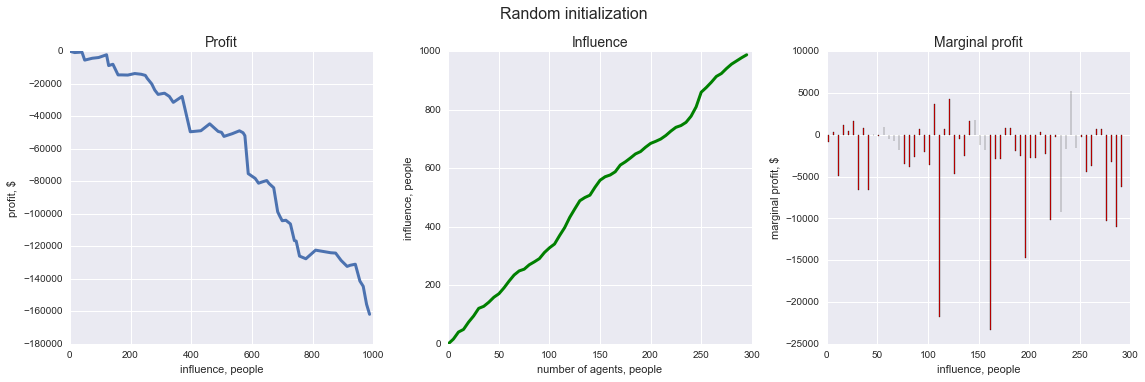

In [302]:
plot_results(influence_rand, profit_rand, marginal_rand, agents_num)
plt.suptitle("Random initialization", fontsize=16, y = 1.05)

### Attempt #2: attract nodes with maximum node degrees. 

The better but still naive approach is just to pay the agents who have the maximum number of connections. Naive, because we might pay the person much money for his or her friends, but those friends might still be unactivated.
<br\>
<br\>
For these purpose we need to sort the nodes according to their degree values and choose K first.

In [122]:
# Sort the nodes according to their degree values
idxs_degr = degrs.argsort()[-1::-1]

In [274]:
influence_degr, profit_degr, marginal_degr = SimulateRes(agents_num, idxs = idxs_degr)

This approach is much better than the previous one. However there is one interesting fact which should be noticed. To achieve positive effect of advertizing campaign we need to make substantial **initial investments**. In other words, we spend around $ 300,000$ $ to pay first 20 people for their own large network of friends. 

But then the marginal profit grows steadily until its optimum at around $130,000$$ with 5500 "infected" people and approximately 55-60 agents.
<br\>
<br\>
Then the marginal profit is becoming negative - we loose money again. The influence as a function of agents number flattens.

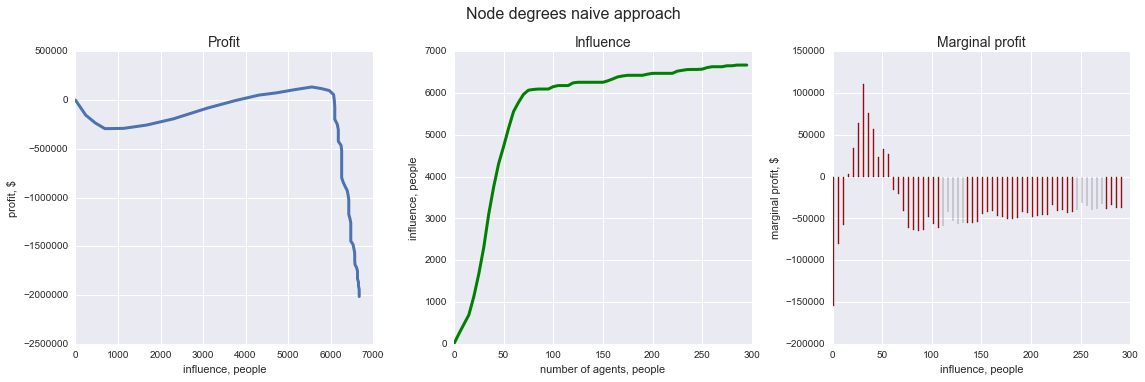

In [275]:
plot_results(influence_degr, profit_degr, marginal_degr, agents_num)
plt.suptitle("Node degrees naive approach", fontsize=16, y = 1.05)

### Attempt #3: utilize centrality measures

Why do not we use another centrality measures, besides of node degrees? 

Several commonly-used centrality measures:

* Closeness centrality
* Betweenness centrality
* Pagerank values
* Eigenvector centrality

Closeness centrality:

In [92]:
centr_clsn = nx.closeness_centrality(G)
centr_clsn = np.array([centr_clsn[k] for k in reordered_nodes])
idxs_clsn = centr_clsn.argsort()[-1::-1]

In [276]:
influence_clsn, profit_clsn, marginal_clsn = SimulateRes(agents_num, idxs = idxs_clsn)

Betweenness centrality:

In [278]:
centr_bwn = nx.betweenness_centrality(G)
centr_bwn = np.array([centr_bwn[k] for k in reordered_nodes])
idxs_bwn = centr_bwn.argsort()[-1::-1]

In [279]:
influence_bwn, profit_bwn, marginal_bwn = SimulateRes(agents_num, idxs = idxs_bwn)

Pagerank:

In [284]:
centr_pagerank = nx.pagerank_scipy(G, max_iter=1000)
centr_pagerank = np.array([centr_pagerank[k] for k in reordered_nodes])
idxs_pagerank = centr_pagerank.argsort()[-1::-1]

In [306]:
influence_pagerank, profit_pagerank, marginal_pagerank = SimulateRes(agents_num, idxs = idxs_pagerank)

Eigenvector centrality:

In [98]:
centr_eig = nx.eigenvector_centrality_numpy(G)
centr_eig = np.array([centr_eig[k] for k in reordered_nodes])
idxs_eig = centr_eig.argsort()[-1::-1]

In [277]:
influence_eig, profit_eig, marginal_eig = SimulateRes(agents_num, idxs = idxs_eig)

Plot results of all metrics.
<br>
<br>
Pagerank value is the best criterion to initialize nodes. Betweenness centrality is slightly worse, whereas closeness and eigenvector centralities do not give good results. 

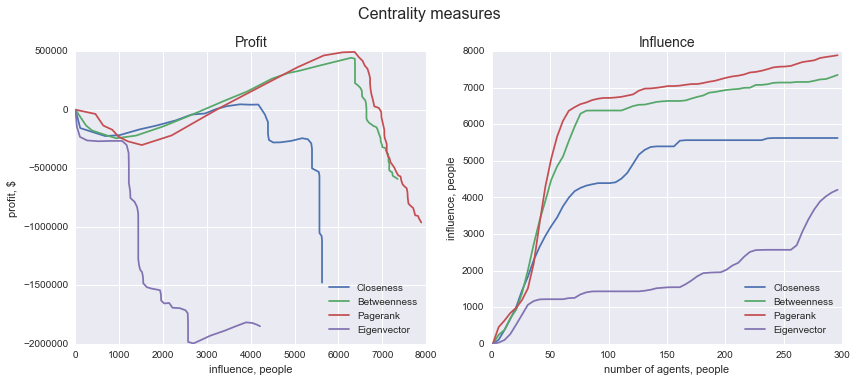

In [293]:
metrics = ['Closeness','Betweenness', 'Pagerank', 'Eigenvector']

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1); plt.xlabel("influence, people"); plt.ylabel("profit, $"); 
plt.plot(influence_clsn, profit_clsn)
plt.plot(influence_bwn, profit_bwn)
plt.plot(influence_pagerank, profit_pagerank)
plt.plot(influence_eig, profit_eig)
plt.legend(metrics, loc = 'best')
plt.title("Profit", fontsize = 14)

plt.subplot(1,2,2); plt.xlabel("number of agents, people"); plt.ylabel("influence, people"); 
plt.plot(range(1, agents_num, 5), influence_clsn)
plt.plot(range(1, agents_num, 5), influence_bwn)
plt.plot(range(1, agents_num, 5), influence_pagerank)
plt.plot(range(1, agents_num, 5), influence_eig)
plt.tight_layout()
plt.legend(metrics, loc = 'best')
plt.suptitle("Centrality measures", fontsize=16, y = 1.05)
plt.title("Influence", fontsize = 14)

In [309]:
print(max(profit_pagerank), max(profit_degr))
print(max(influence_pagerank), max(influence_degr))

493600 133750
7890 6670


**Pagerank allows us to easily increase profit from the campaign by 3.5 times and total influence by 15% in comparison with the conventional node degree criterion.**
<br>
<br>
Nevertheless, Pagerank initialization still requires initial investments until marginal profit becomes positive.

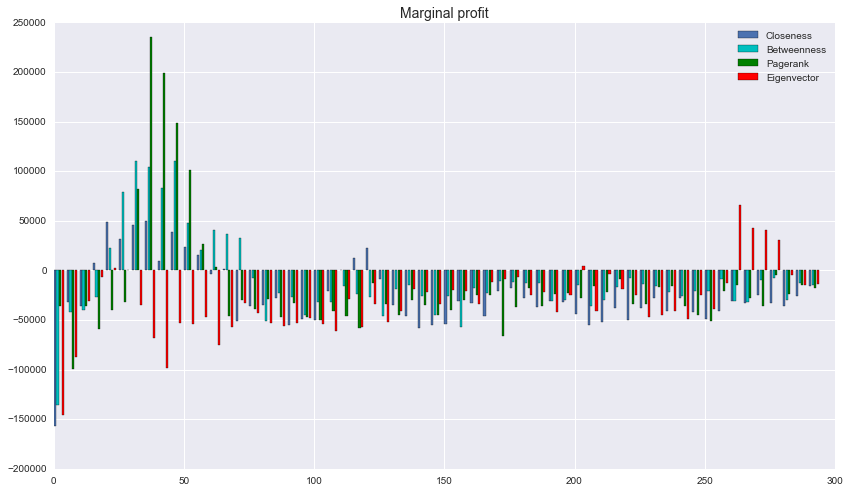

In [305]:
plt.figure(figsize=(14, 8))
plt.bar(interval[:-1], marginal_clsn); 
plt.bar(interval[:-1]+1, marginal_bwn, color = 'c'); 
plt.bar(interval[:-1]+2, marginal_pagerank, color = 'g'); 
plt.bar(interval[:-1]+3, marginal_eig, color = 'r')
plt.legend(metrics, loc = 'best')
plt.title("Marginal profit", fontsize = 14)

### Attempt #4: "Greedy" optimization

The smarter way to initialize nodes - make use of greedy optimization. 
<br\>
<br\>
It is computationally hard to apply this approach even for such small network with all given assumptions. Therefore, let's assume further that we will use the greedy approach only for nodes with the highest Pagerank values - as it turned out to be the best metric among other centrality measures. This simplification can substantially relax requirements to computational resources.

In [266]:
# Choose candidates with the best Pagerank values
centr_pagerank = nx.pagerank_scipy(G, max_iter=1000)
centr_pagerank_sort = sorted(centr_pagerank, key = centr_pagerank.get, reverse=True)[:300]
candidates_pagerank = np.array([1 if x in centr_pagerank_sort else 0 for x in reordered_nodes])

In [254]:
# Function for greedy optimization
def InfluenceProp_greedy(A, K_num, candidates, theta):
    K = 0
    influence_total = []
    profit_total = []
    greedyActive = np.zeros((A.shape[0],), dtype=bool)
    idxs_candid = np.where(candidates>0)[0]
    while K < K_num:
        influence = np.zeros((A.shape[0],), dtype=int)
        profit = np.zeros((A.shape[0],), dtype=int)
        for j in idxs_candid:
            if greedyActive[j] != 0:
                continue
            initActive = greedyActive.copy()
            initActive[j] = 1
            influence[j] = InfluenceProp(A, initActive, theta).sum()
            profit[j] = influence[j] * 250 - degrs[j] * 300
        jActive = np.argmax(profit)
        greedyActive[jActive] = 1
        influence_total.append(influence[jActive])
        profit_total.append(profit[jActive])
        K += 1
        print(K)
    return profit_total, influence_total

In [ ]:
# Greedy optimization
results_greedy = InfluenceProp_greedy(adj_matrix, 300, candidates_pagerank, theta)
profit_greedy = results_greedy[0]
influence_greedy = results_greedy[1]

In [310]:
marginal_greedy = np.array(profit_greedy[1:]) - np.array(profit_greedy[:-1])

Greedy optimization, even based on Pagerank values gives outstanding gain: 3x growth in profit compared with simple Pagerank initialization. 


However the influence at the optimal profit remains the same. It means that we do not "infect" more people, but reduce our costs on campaign by choosing more optimal agents.

And, finally, we do not need to bear any initial investments - marginal profit is positive from the first attracted agent. The optimal number og agents is slightly lower than 300, when marginal profit becomes negative.

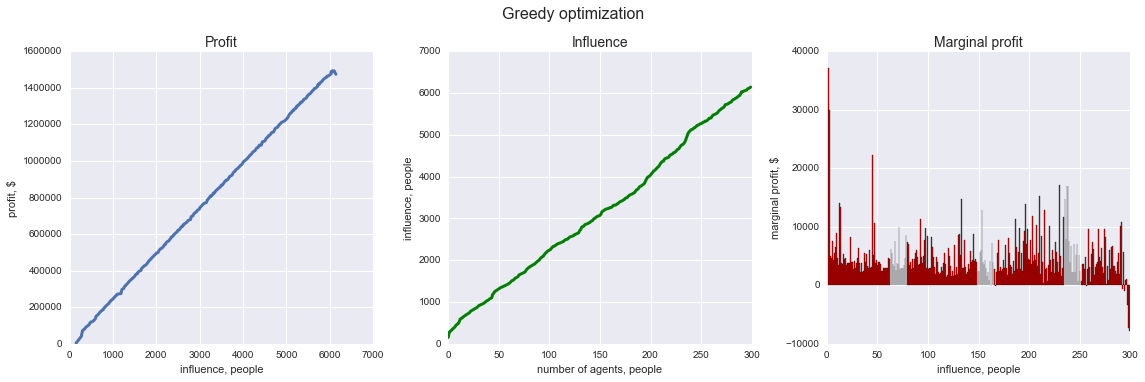

In [323]:
plt.figure(figsize = (16, 5))
plt.subplot(1,3,1); plt.xlabel("influence, people"); plt.ylabel("profit, $"); 
plt.plot(influence_greedy, profit_greedy, lw = 3)
plt.title("Profit", fontsize = 14)

plt.subplot(1,3,2); plt.xlabel("number of agents, people"); plt.ylabel("influence, people"); 
plt.plot(range(agents_num), influence_greedy, 'g',lw = 3)
plt.title("Influence", fontsize = 14)
plt.subplot(1,3,3)
plt.bar(range(1, agents_num), marginal_greedy, color = 'r') 
plt.xlabel("influence, people"); 
plt.ylabel("marginal profit, $"); 
plt.title("Marginal profit", fontsize = 14)
plt.tight_layout()
plt.suptitle("Greedy optimization", fontsize=16, y = 1.05)

### Conclusion

Greedy optimization, though being simlified, has shown substantial advantage over other initialization methods for profit optimization goal.

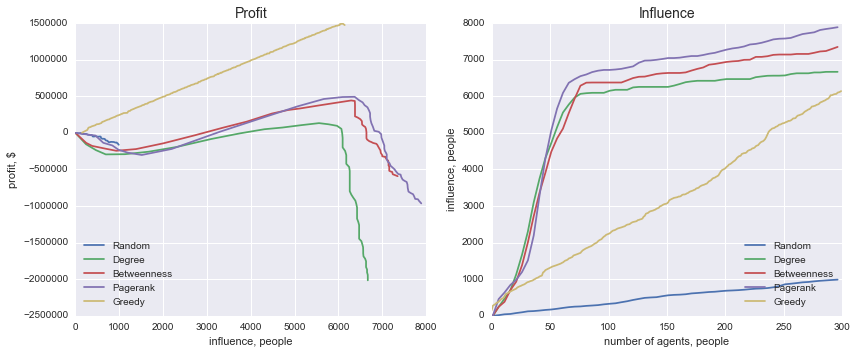

In [331]:
metrics = ['Random', 'Degree', 'Betweenness', 'Pagerank', 'Greedy']

plt.figure(figsize = (12, 5))
plt.subplot(1,2,1); plt.xlabel("influence, people"); plt.ylabel("profit, $"); 
plt.plot(influence_rand, profit_rand)
plt.plot(influence_degr, profit_degr)
plt.plot(influence_bwn, profit_bwn)
plt.plot(influence_pagerank, profit_pagerank)
plt.plot(influence_greedy, profit_greedy)
plt.legend(metrics, loc = 'best')
plt.title("Profit", fontsize = 14)

plt.subplot(1,2,2); plt.xlabel("number of agents, people"); plt.ylabel("influence, people"); 
plt.plot(range(1, agents_num, 5), influence_rand)
plt.plot(range(1, agents_num, 5), influence_degr)
plt.plot(range(1, agents_num, 5), influence_bwn)
plt.plot(range(1, agents_num, 5), influence_pagerank)
plt.plot(range(agents_num), influence_greedy)
plt.tight_layout()
plt.legend(metrics, loc = 'lower right')
plt.title("Influence", fontsize = 14)

However, profit maximization does not mean influence maximization. It is shown above that greedy optimization in our case works little bit worse in terms of influence or auditory size.